# Imports and initialization

In [1]:
import torch
from model_cond import VAE
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torchvision.transforms as transforms
from tqdm import tqdm
from torchmetrics.image import TotalVariation

In [2]:
DEVICE = "cuda"

model = VAE().to(DEVICE)
model.load_state_dict(torch.load("train_results/model_weights_final.pth"))
to_tensor = torchvision.transforms.functional.to_tensor

dummy input shape  torch.Size([4096])


In [3]:
def plot_loss(loss):
    f,ax=plt.subplots(figsize=(5,3))
    plt.plot(loss['optim_loss'])
    plt.suptitle("Optimization loss");

In [4]:
def plot_image(img):

    img = img[0].permute(1,2,0).detach().cpu()
    height, width, depth = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width/64 , height/64
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img.numpy(), interpolation='nearest')


In [5]:
def plot_comparison(before, after):

    before = before[0].permute(1,2,0).detach().cpu()
    after  = after[0].permute(1,2,0).detach().cpu()

    f, axarr = plt.subplots(2)
    f.tight_layout()
    axarr[0].imshow(before)
    axarr[0].set_title("Before") 
    axarr[1].imshow(after)
    axarr[1].set_title("After") 

In [6]:
transform_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

# VAE Inference demo

For this homework project, I created a simple toy VAE with the PolyHaven dataset, which learns to reconstruct given samples of environment maps. Then, I will use the VAE to optimize on its latent code using the CLIP-based loss given a prompt. In addition to the traditional VAE losses, I added a CLIP-based loss using the fine-tuned model from clip_finetune.ipynb.
For the code of the VAE, the reference is at
- vae_model.py
- vae_train.py

Please note that the quality of the VAE may not be optimal, but the goal here is to experiment with the CLIP-based optimization

In [7]:
x = to_tensor(Image.open("dataset/polyhaven_png_128/cannon_1k.png")).unsqueeze(0).to(DEVICE) #lenong_3_1k.png
print(x.shape)

torch.Size([1, 3, 128, 256])


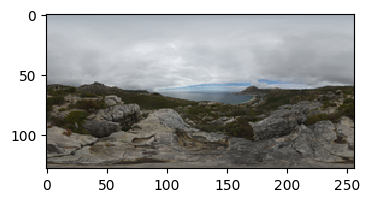

In [8]:
plot_image(x)

In [9]:
# Normalize x as intended for input in the VAE
x_norm = transform_normalize(x)

/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


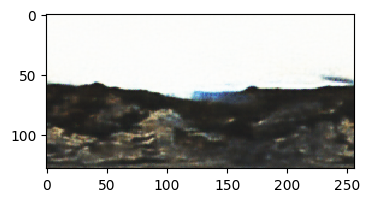

In [10]:
def full_inference(model, input):
    model.eval()
    with torch.no_grad():
            mu, sigma = model.encode(input)
            z = model.reparameterize(mu, sigma)
            output = model.decode(z)
            
    return output

y = full_inference(model, x_norm)

plot_image(y)

# CLIP loss

In [11]:
class CustomCLIPLoss(torch.nn.Module):

    def __init__(self, clip_model="ViT-B/32", checkpoint=None):#, resize=224):
        super(CustomCLIPLoss, self).__init__()
        self.model, clip_preprocess = clip.load(clip_model, device="cuda", jit=False)
        
        if checkpoint is not None:
            # source: https://github.com/openai/CLIP/issues/83
            ckpt = torch.load(checkpoint)
            self.model.load_state_dict(ckpt)
    
        # Remove from the CLIP preprocessor the PIL related operations
        self.preprocess = transforms.Compose([
                clip_preprocess.transforms[0],
                clip_preprocess.transforms[1],
                clip_preprocess.transforms[4]
        ])

        '''
        self.preprocess = transforms.Compose([
            transforms.Resize(resize),         
            transforms.CenterCrop(resize),
            transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
        ])
        '''      
    def forward(self, image, text):
        image = self.preprocess(image)
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

In [12]:
clip_loss = CustomCLIPLoss()

# CLIP optimization

In [13]:
def get_optimizer(var, lr, weight_decay=0):
    var_optim = var.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([var_optim], lr=lr, weight_decay=weight_decay)
    return var_optim, optimizer

## Optimization on plain pixels

In this example, I show that optimizing on plain pixels is not enough: the sparsity nature of the problems makes it impossible for the optimizer to reconstruct what is given in the prompt, resulting in a noisy image

In [14]:
img_optim, optimizer = get_optimizer(x, lr=1e-3, weight_decay=1e-5)

  0%|          | 0/1600 [00:00<?, ?it/s]/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1600/1600 [01:24<00:00, 18.96it/s, loss=0.0825]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


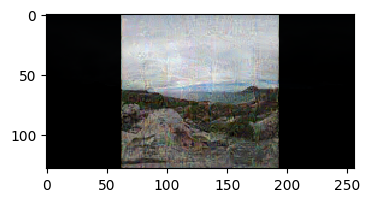

In [15]:
#prompt = "sunset environment, horizon, high contrast, puresky"
#prompt = "derelict, fluorescent, concrete, industrial, backplates, indoor, urban, morning-afternoon, medium contrast, artificial light"
prompt = "sunset"
text = clip.tokenize(prompt).to(device="cuda")

history={}
history={'optim_loss':[]}

loop = tqdm(range(1600))

for it in loop:

    loss_clip = clip_loss(img_optim, text)
    loss = loss_clip
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loop.set_postfix(loss=loss.item())
    history['optim_loss'].append(loss.item())

plot_image(img_optim)

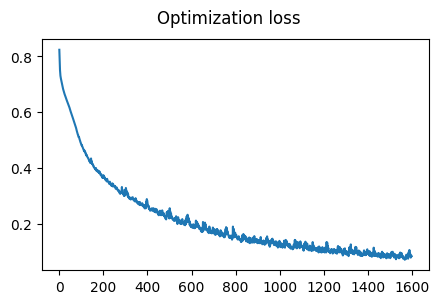

In [16]:
plot_loss(history)

## Optimization on latent space

By optimizing on the latent code of the VAE, the optimizer is able to approach the target prompt, because the decoder has knowledge of the domain and it's able to reconstruct samples from the modified latent code. 

In this case, the goal of the inversion problem is: 
- "given a textual input, what is the latent code such that the decoded image resembles the CLIP embedding of the prompt?"

In [17]:
def decode_z(model, z):
    model.eval()

    mu, sigma = model.get_mu_logvar(z)
    z_rep = model.reparameterize(mu, sigma)
    
    output = model.decode(z_rep)
    return output

In [18]:
tv = TotalVariation().to(DEVICE)

Encode the image to get the latent code

In [19]:
z = model.encode_only(x_norm)
print(z)

tensor([[-3.2611, -0.5907, -2.0552,  ...,  0.9451, -1.9801, -1.9919]],
       device='cuda:0', grad_fn=<ViewBackward0>)


Optimize on the latent code of the envmap

In [20]:
z_optim, optimizer = get_optimizer(z, lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

In [21]:
history={'optim_loss':[]}

100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s, loss=0.714, loss_clip=0.714, loss_tv=5.18e+3]


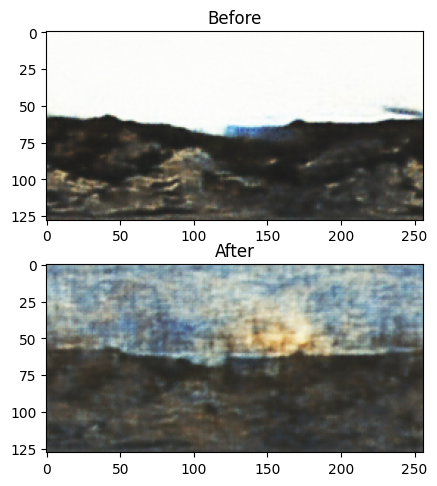

In [22]:
prompt = "sunset"
text = clip.tokenize(prompt).to(device="cuda")

loop = tqdm(range(1600))

history={}
history={'optim_loss':[]}
for it in loop:
    #tf_img = decode_mu_logvar(model, parameters_optim.mu, parameters_optim.logvar)
    tf_img = decode_z(model, z_optim)
    loss_clip = clip_loss(tf_img, text)

    tv_loss = tv(tf_img)
    loss = loss_clip #+ 1e-7*tv_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    loop.set_postfix(loss=loss.item(), loss_clip=loss_clip.item(), loss_tv=tv_loss.item())
    history['optim_loss'].append(loss.item())


plot_comparison(y, tf_img)

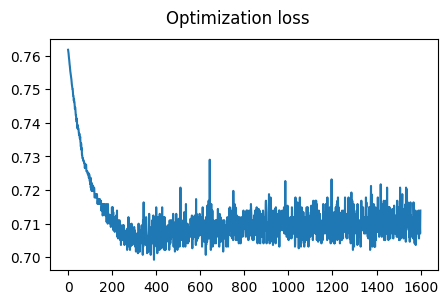

In [23]:
plot_loss(history)

## Optimization with fine-tuned CLIP

Inside clip_finetuning.ipynb, I finetuned the CLIP model using as captions the tags of the environment maps in the PolyHaven dataset. The following is a test with the fine-tuned model.
The model was fine-tuned with two types of images, using the PolyHaven metadatas (tags, categories) as captions: 
- Plain PolyHaven environment maps
- The output of the VAE

### PolyHaven model

In [24]:
if clip_loss in locals():
    del clip_loss
    torch.cuda.empty_cache()

#clip_loss = CustomCLIPLoss(clip_model="RN50x4", checkpoint="clip_checkpoints/clip_finetuned_polyhaven.pt", resize=288)
clip_loss = CustomCLIPLoss(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_polyhaven.pt")

z = model.encode_only(x_norm)
print(z)

z_optim, optimizer = get_optimizer(z, lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

tensor([[-3.2611, -0.5907, -2.0552,  ...,  0.9451, -1.9801, -1.9919]],
       device='cuda:0', grad_fn=<ViewBackward0>)


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s, loss=0.719]


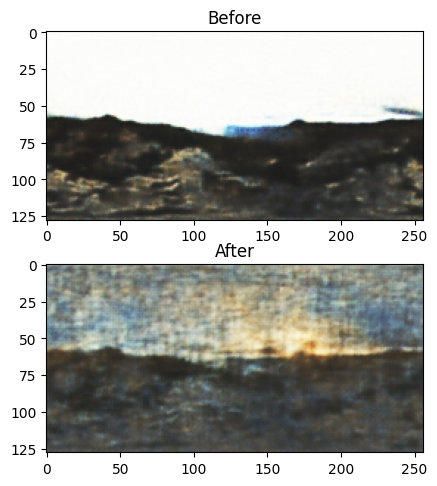

In [25]:
prompt = "sunset" # environment, sunny, high contrast
text = clip.tokenize(prompt).to(device="cuda")

loop = tqdm(range(1600))

history={}
history={'optim_loss':[]}
for it in loop:
    tf_img = decode_z(model, z_optim)

    loss_clip = clip_loss(tf_img, text)
    tv_loss = tv(tf_img)
    loss = loss_clip
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    loop.set_postfix(loss=loss.item())
    history['optim_loss'].append(loss.item())

plot_comparison(y, tf_img)

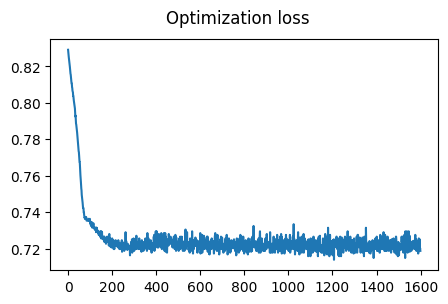

In [26]:
plot_loss(history)

### VAE model

In [27]:
if clip_loss in locals():
    del clip_loss
    torch.cuda.empty_cache()

#clip_loss = CustomCLIPLoss(clip_model="RN50x4", checkpoint="clip_checkpoints/clip_finetuned_polyhaven.pt", resize=288)
clip_loss = CustomCLIPLoss(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_vae.pt")

z = model.encode_only(x_norm)
print(z)

z_optim, optimizer = get_optimizer(z, lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

tensor([[-3.2611, -0.5907, -2.0552,  ...,  0.9451, -1.9801, -1.9919]],
       device='cuda:0', grad_fn=<ViewBackward0>)


100%|██████████| 1600/1600 [01:44<00:00, 15.32it/s, loss=0.698]


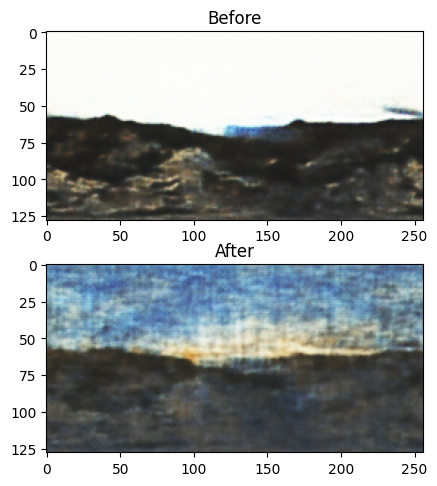

In [28]:
prompt = "sunset" # environment, sunny, high contrast
text = clip.tokenize(prompt).to(device="cuda")

loop = tqdm(range(1600))

history={}
history={'optim_loss':[]}
for it in loop:
    tf_img = decode_z(model, z_optim)

    loss_clip = clip_loss(tf_img, text)
    tv_loss = tv(tf_img)
    loss = loss_clip
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    loop.set_postfix(loss=loss.item())
    history['optim_loss'].append(loss.item())

plot_comparison(y, tf_img)

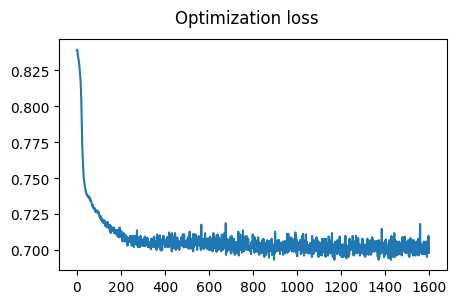

In [29]:
plot_loss(history)

## [To-Do] Maybe unnecessary cells

In [30]:
def decode_mu_logvar(model, mu, sigma):
    model.eval()
    z_rep = model.reparameterize(mu, sigma)
    output = model.decode(z_rep)
    return output

In [31]:
import torch.nn as nn
class LatentParameters(nn.Module):
    def __init__(self, mu, logvar):
        super(LatentParameters, self).__init__()
        self.mu = nn.Parameter(mu.clone().detach().requires_grad_(True))
        self.logvar = nn.Parameter(logvar.clone().detach().requires_grad_(True))


In [32]:
def get_optimizer_distrib(mu, logvar, lr, weight_decay=0):
    parameters = LatentParameters(mu, logvar)
    optimizer = torch.optim.Adam(parameters.parameters(), lr=lr, weight_decay=weight_decay)
    return parameters, optimizer

In [33]:
#z_optim, optimizer = get_optimizer(z, lr=1e-2, weight_decay=1e-3) #1e-3
mu, logvar = model.encode(x_norm)
parameters_optim, optimizer = get_optimizer_distrib(mu, logvar, lr=1e-2, weight_decay=1e-3)#, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)